In [ ]:
!pip install rasterio

!pip install radiant_mlhub

In [ ]:
from IPython.display import clear_output

!python --version

!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh

!chmod +x mini.sh

!bash ./mini.sh -b -f -p /usr/local

!conda install -q -y jupyter

!conda install -q -y google-colab -c conda-forge

!python -m ipykernel install --name "py39" --user

clear_output()

!python --version

Python 3.9.1


In [ ]:
!pip install rasterio==1.3.0

!pip install radiant_mlhub==0.5.2

##Downloading Data

In [ ]:
%%writefile my_downloader.sh

import rasterio

from radiant_mlhub import Dataset

import radiant_mlhub

print(rasterio.__version__, radiant_mlhub.__version__)

import os

import glob

Full_bands = [ 'B01','B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

selected_bands = Full_bands 

#define dataset collection_id , assets and necessary paths to collections

main = 'ref_agrifieldnet_competition_v1'

assets = ['field_ids','raster_labels']

source_collection = f'{main}_source'

train_label_collection = f'{main}_labels_train'

test_label_collection = f'{main}_labels_test'

api_key = "58eba2df5be9b75483d17bf844d250b36d641d94c4a6584c025f9bd2953dfd59"

os.environ['MLHUB_API_KEY'] = api_key # getpass.getpass(prompt="MLHub API Key: ")

dataset = Dataset.fetch(main)

my_filter = dict(

ref_agrifieldnet_competition_v1_labels_train=assets,

ref_agrifieldnet_competition_v1_labels_test=[assets[0]],

ref_agrifieldnet_competition_v1_source=selected_bands

)

dataset.download(collection_filter=my_filter)







Overwriting my_downloader.sh


In [ ]:
!python my_downloader.sh

1.3.0 0.5.2
unarchive ref_agrifieldnet_competition_v1.tar.gz: 100% 6186/6186 [00:00<00:00, 62955.01it/s]
filter by collection ids and asset keys: 231716it [00:00, 1292546.05it/s]
download assets: 100% 17641/17641 [21:46<00:00, 13.50it/s]


In [ ]:
from radiant_mlhub import Dataset
import radiant_mlhub
import rasterio
#import libraries
import os
import glob
import json
import getpass
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:

Full_bands = ['B01', 'B02', 'B03', 'B04','B05', 'B06', 'B07', 'B08','B8A', 'B09', 'B11', 'B12']

selected_bands =Full_bands 
selected_bands

In [ ]:
#define dataset collection_id , assets and necessary paths to collections

main = 'ref_agrifieldnet_competition_v1'

assets = ['field_ids','raster_labels']

source_collection = f'{main}_source'
train_label_collection = f'{main}_labels_train'
test_label_collection = f'{main}_labels_test'

In [ ]:
#load collection json and retrieve all unique folder ids 
#use all unique folder ids to create a list of field and label paths for all tiles

with open (f'{main}/{train_label_collection}/collection.json') as f:
    train_json = json.load(f)
    
train_folder_ids = [i['href'].split('_')[-1].split('.')[0] for i in train_json['links'][4:]]

train_field_paths = [f'{main}/{train_label_collection}/{train_label_collection}_{i}/field_ids.tif' for i in train_folder_ids]
train_label_paths = [f'{main}/{train_label_collection}/{train_label_collection}_{i}/raster_labels.tif' for i in train_folder_ids]

In [ ]:
#create dataset for folder_ids and field_paths

competition_train_data = pd.DataFrame(train_folder_ids, columns=['unique_folder_id'])
competition_train_data['field_paths'] = train_field_paths
competition_train_data

,unique_folder_id,field_paths
0,28852,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1,d987c,ref_agrifieldnet_competition_v1/ref_agrifieldn...
2,ca1d4,ref_agrifieldnet_competition_v1/ref_agrifieldn...
3,2ec18,ref_agrifieldnet_competition_v1/ref_agrifieldn...
4,7575d,ref_agrifieldnet_competition_v1/ref_agrifieldn...
...,...,...
1160,516f8,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1161,b8afb,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1162,e3ad4,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1163,3ab12,ref_agrifieldnet_competition_v1/ref_agrifieldn...


In [ ]:
with open (f'{main}/{test_label_collection}/collection.json') as f:
    test_json = json.load(f)
    
test_folder_ids = [i['href'].split('_')[-1].split('.')[0] for i in test_json['links'][4:]]

test_field_paths = [f'{main}/{test_label_collection}/{test_label_collection}_{i}/field_ids.tif' for i in test_folder_ids]

In [ ]:
competition_test_data = pd.DataFrame(test_folder_ids , columns=['unique_folder_id'])
competition_test_data['field_paths'] = test_field_paths
competition_test_data

,unique_folder_id,field_paths
0,6199c,ref_agrifieldnet_competition_v1/ref_agrifieldn...
1,6c81d,ref_agrifieldnet_competition_v1/ref_agrifieldn...
2,1ebeb,ref_agrifieldnet_competition_v1/ref_agrifieldn...
3,586a2,ref_agrifieldnet_competition_v1/ref_agrifieldn...
4,65812,ref_agrifieldnet_competition_v1/ref_agrifieldn...
...,...,...
702,b5766,ref_agrifieldnet_competition_v1/ref_agrifieldn...
703,2f048,ref_agrifieldnet_competition_v1/ref_agrifieldn...
704,30f20,ref_agrifieldnet_competition_v1/ref_agrifieldn...
705,f87d2,ref_agrifieldnet_competition_v1/ref_agrifieldn...


##Data Preparation-Feature Engineering

###Field pixel size

In [ ]:
train_label_collection = f'{main}_labels_train'
test_label_collection = f'{main}_labels_test'

In [ ]:
#We will use the number of pixel per field as an indicator of the size of the field
def get_pixels_perField(collection, folder_ids):

    D = {}
    pbar = tqdm(folder_ids)
    pbar.set_description(f'Extracting {collection}',)

    for idx in pbar:
        with rasterio.open(f'./{main}/{collection}/{collection}_{idx}/field_ids.tif') as field:
            arr = field.read()
            
            L=list(np.unique(arr))
            L.remove(0)
            for f in L:
              for i in range(256):
                for j in range(256):
                  if(arr[0][i][j]==f):
                    try:
                      D[f]+=1
                    except KeyError:
                      D[f]=1


    return D

In [ ]:
D=get_pixels_perField(train_label_collection, train_folder_ids)

Extracting ref_agrifieldnet_competition_v1_labels_train: 100%|██████████| 1165/1165 [03:22<00:00,  5.77it/s]


In [ ]:
train_fields_pixels=pd.DataFrame()
train_fields_pixels['field_id']=list(D.keys())
train_fields_pixels['nbr_pixels']=list(D.values())
train_fields_pixels

,field_id,nbr_pixels
0,756,14
1,757,21
2,1372,59
3,1374,36
4,1986,14
...,...,...
5546,1057,34
5547,1058,12
5548,1382,34
5549,1383,9


In [ ]:
train_fields_pixels.to_csv('train_pixels.csv',index=False)

In [ ]:
D=get_pixels_perField(test_label_collection, test_folder_ids)

Extracting ref_agrifieldnet_competition_v1_labels_test: 100%|██████████| 707/707 [00:54<00:00, 12.90it/s]


In [ ]:
test_fields_pixels=pd.DataFrame()
test_fields_pixels['field_id']=list(D.keys())
test_fields_pixels['nbr_pixels']=list(D.values())
test_fields_pixels

,field_id,nbr_pixels
0,5407,131
1,6309,21
2,6310,17
3,6311,18
4,6314,15
...,...,...
1525,2127,40
1526,3286,13
1527,3595,33
1528,626,16


In [ ]:
test_fields_pixels.to_csv('test_pixels.csv',index=False)

###Tile correspending to each field

In [ ]:
def get_field_ids_per_chips(collection, folder_ids):

    chips = {}

    pbar = tqdm(folder_ids)
    pbar.set_description(f'Extracting {collection}',)

    for idx in pbar:
        with rasterio.open(f'./{main}/{collection}/{collection}_{idx}/field_ids.tif') as src:
            field_data = src.read()
            field_data = list(np.unique(field_data))
            field_data.remove(0)
            chips[idx] = field_data

    return chips

In [ ]:
train_field_ids_per_chip = get_field_ids_per_chips(train_label_collection, train_folder_ids)
test_field_ids_per_chip = get_field_ids_per_chips(test_label_collection, test_folder_ids)

Extracting ref_agrifieldnet_competition_v1_labels_train: 100%|██████████| 1165/1165 [00:04<00:00, 281.69it/s]
Extracting ref_agrifieldnet_competition_v1_labels_test: 100%|██████████| 707/707 [00:02<00:00, 281.59it/s]


In [ ]:
#this function is used to verify is the field already exists in a chip 
#in order to capture fields corresponding to more than one chip
def checkKey(dic, key):
    if key in dic.keys():
        return True
    return False    
    

In [ ]:
D=dict()
for key,value in train_field_ids_per_chip.items():
  for v in value:
    if(checkKey(D, v)):
      D[v]=str(D[v])+'+'+key
    else:  
      D[v]=key

In [ ]:
chips_mapping_train=pd.DataFrame()
chips_mapping_train['chip']=list(D.values())
chips_mapping_train['field_id']=list(D.keys())

In [ ]:
D=dict()
for key,value in test_field_ids_per_chip.items():
  for v in value:
    if(checkKey(D, v)):
      D[v]=str(D[v])+'+'+key
    else:  
      D[v]=key

In [ ]:
chips_mapping_test=pd.DataFrame()
chips_mapping_test['chip']=list(D.values())
chips_mapping_test['field_id']=list(D.keys())
chips_mapping_test

,chip,field_id
0,6199c,5407
1,6c81d,6309
2,6c81d,6310
3,6c81d,6311
4,6c81d,6314
...,...,...
1525,2f048,2127
1526,30f20,3286
1527,30f20,3595
1528,f87d2,626


In [ ]:
chips_mapping_train.to_csv('chips_mapping_train.csv',index=False)
chips_mapping_test.to_csv('chips_mapping_test.csv',index=False)

###Extracting bands + Coordinates of each chip

In [ ]:
#Extract field_crop Pairs 

def field_crop_extractor(crop_field_files):
    field_crops = {}

    for label_field_file in tqdm(crop_field_files):
        with rasterio.open(f'{main}/{train_label_collection}/{train_label_collection}_{label_field_file}/field_ids.tif') as src:
            field_data = src.read()[0]
        with rasterio.open(f'{main}/{train_label_collection}/{train_label_collection}_{label_field_file}/raster_labels.tif') as src:
            crop_data = src.read()[0]
    
        for x in range(0, crop_data.shape[0]):
            for y in range(0, crop_data.shape[1]):
                field_id = str(field_data[x][y])
                field_crop = crop_data[x][y]

                if field_crops.get(field_id) is None:
                    field_crops[field_id] = []

                if field_crop not in field_crops[field_id]:
                    field_crops[field_id].append(field_crop)
    
    field_crop_map  =[[k, v[0]]  for k, v in field_crops.items() ]
    field_crop = pd.DataFrame(field_crop_map , columns=['field_id','crop_id'])

    return field_crop[field_crop['field_id']!='0']

In [ ]:
field_crop_pair = field_crop_extractor(train_folder_ids)
field_crop_pair

100%|██████████| 1165/1165 [02:04<00:00,  9.36it/s]


,field_id,crop_id
1,757,6
2,756,6
3,1372,5
4,1374,1
5,1986,4
...,...,...
5547,1385,2
5548,789,2
5549,923,5
5550,924,1


In [ ]:
# each row is a pixel and each column is one of the band observations mapped to its corresponding field. 
# I also extract the bbox of each tile. 


img_sh = 256
n_selected_bands=5# len(selected_bands)

n_obs = 1  #imagery per chip(no time series)

def feature_extractor(data_ ,   path ):
    '''
        data_: Dataframe with 'field_paths' and 'unique_folder_id' columns
        path: Path to source collections files

        returns: pixel dataframe with corresponding field_ids
        '''
    
    X = np.empty((0, n_selected_bands * n_obs))
    X_tile = np.empty((img_sh * img_sh, 0))
    X_arrays = []
        
    field_ids = np.empty((0, 1))
    coordinates=[]
    chips=[]
    for idx, tile_id in tqdm(enumerate(data_['unique_folder_id'])):
        
        field_src =   rasterio.open( data_['field_paths'].values[idx])
        field_array = field_src.read(1)
        chips.append( tile_id )
        field_ids = np.append(field_ids, field_array.flatten())
  
        
        bands_src = [rasterio.open(f'{main}/{path}/{path}_{tile_id}/{band}.tif') for band in selected_bands]
        bands_array = [np.expand_dims(band.read(1).flatten(), axis=1) for band in bands_src]
        
        X_tile = np.hstack(bands_array)

        X_arrays.append(X_tile)
        #/content/ref_agrifieldnet_competition_v1/ref_agrifieldnet_competition_v1_source/ref_agrifieldnet_competition_v1_source_001c1/ref_agrifieldnet_competition_v1_source_001c1.json
        with open (f'{main}/{path}/{path}_{tile_id}/{path}_{tile_id}.json') as f:
            _json = json.load(f)
        coordinates.append(_json['bbox'])
        
        

    X = np.concatenate(X_arrays)
    
    data = pd.DataFrame(X, columns=selected_bands)

    data['field_id'] = field_ids

    return data[data['field_id']!=0],chips,coordinates

In [ ]:
train_data,field_ids,coordinates = feature_extractor(competition_train_data, source_collection)
train_data

1165it [02:46,  7.00it/s]


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
11031,43,39,38,38,41,54,63,61,64,12,57,37,757.0
11287,43,39,38,38,42,57,67,63,72,12,63,42,757.0
11288,43,39,38,37,41,59,69,65,78,12,68,43,757.0
11289,43,38,37,36,41,59,69,64,78,12,68,43,757.0
11543,43,39,38,38,42,57,67,64,72,12,63,42,757.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76341478,48,46,48,55,56,63,71,66,78,12,86,66,791.0
76341479,48,46,49,56,56,63,71,66,78,12,86,66,924.0
76341480,48,47,49,56,57,66,73,66,78,12,87,69,924.0
76341734,48,46,49,56,56,63,71,67,78,12,86,66,791.0


In [ ]:
geo=pd.DataFrame(field_ids,columns=['chip'])
geo['bbox']=coordinates
geo

,chip,bbox
0,28852,"[82.29382899483097, 27.32713829135441, 82.3199..."
1,d987c,"[81.54278059765775, 27.193543671621423, 81.568..."
2,ca1d4,"[81.5432292600233, 27.28598875637792, 81.56921..."
3,2ec18,"[87.71232081886878, 25.343603898226164, 87.737..."
4,7575d,"[83.67644488209265, 19.104289532145508, 83.701..."
...,...,...
1160,516f8,"[83.85019591601247, 19.309674021821294, 83.874..."
1161,b8afb,"[76.9226069295929, 24.662353415107034, 76.9482..."
1162,e3ad4,"[81.13052370114117, 28.28081255432777, 81.1566..."
1163,3ab12,"[81.49251813933866, 27.517298977274603, 81.518..."


In [ ]:
geo.to_csv('train_geo.csv',index=False)

In [ ]:
test_data,chips_test,coords = feature_extractor(competition_test_data,  source_collection)
test_data

707it [01:08, 10.26it/s]


,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id
35283,39,35,35,35,38,48,55,59,60,11,53,39,5407.0
35284,39,34,33,34,37,49,58,58,63,11,54,40,5407.0
35538,39,36,36,37,39,59,70,56,76,14,55,37,5407.0
35539,39,35,36,34,39,59,70,75,76,14,55,37,5407.0
35540,39,33,34,31,37,70,85,79,90,14,54,34,5407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46270205,43,42,43,51,52,57,64,59,70,12,76,55,5705.0
46270206,43,39,39,45,46,50,56,51,61,12,70,52,5705.0
46270207,43,39,39,44,46,50,56,50,61,12,70,52,5705.0
46270462,43,39,40,45,46,50,56,54,61,12,70,52,5705.0


In [ ]:
geo_test=pd.DataFrame(chips_test,columns=['chip'])
geo_test['bbox']=coords
geo_test

,chip,bbox
0,6199c,"[76.84606653839002, 24.617101431568184, 76.871..."
1,6c81d,"[87.30587182973441, 25.57625793721506, 87.3314..."
2,1ebeb,"[81.62462146158417, 27.95583173763873, 81.6507..."
3,586a2,"[83.07052290023543, 19.274051111929083, 83.095..."
4,65812,"[83.41235872444402, 19.339169627559386, 83.437..."
...,...,...
702,b5766,"[76.66972314175382, 24.66542007779033, 76.6953..."
703,2f048,"[81.28622938826972, 27.93390555987311, 81.3123..."
704,30f20,"[81.59459446124482, 27.216435666106115, 81.620..."
705,f87d2,"[82.21596186186991, 27.30474312284826, 82.2420..."


In [ ]:
geo_test.to_csv('test_geo.csv',index=False)

In [ ]:
train_data.field_id = [str(int(i)) for i in train_data.field_id.values]


In [ ]:
train_df = pd.merge(train_data, field_crop_pair , on='field_id' )
train_df.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,field_id,crop_id
0,43,39,38,38,41,54,63,61,64,12,57,37,757,6
1,43,39,38,38,42,57,67,63,72,12,63,42,757,6
2,43,39,38,37,41,59,69,65,78,12,68,43,757,6
3,43,38,37,36,41,59,69,64,78,12,68,43,757,6
4,43,39,38,38,42,57,67,64,72,12,63,42,757,6


In [ ]:
train_data.field_id = [str(int(i)) for i in train_data.field_id.values]


###Vegetation indices

for feature enginnering i'm creating around 90 vegetation index

In [ ]:
def FE(df) : 
  #SOIL
  df['SARVI2']=2.5 * (df['B08'] - df['B04']) / (1.0 + df['B08'] + 6.0 * df['B04'] - 7.5 * df['B02'])
  df['SAVI3']=(1.0 + 0.5) * (df['B08'] - df['B04']) / (df['B08'] + df['B04'] + 0.5)
  df['SAVI'] = ((df['B08'] - df['B04'])/(df['B08'] + df['B04'] + 0.33)) * (1 + 0.33)
  df['SBL']=df['B09'] - 2.4 * df['B04']
  df['SC']=(df['B11'] - df['B08']) / (df['B11'] + df['B08'])
  df['SLAVI']=df['B08'] / (df['B04'] + df['B12'])
  df['ATSAVI']=1.22 * (df['B08'] - 1.22 * df['B04'] - 0.03) / (1.22 * df['B08'] + df['B04'] - 1.22 * 0.03 + 0.08 * (1.0 + pow(1.22, 2.0)))
  df['AFRI1600']=df['B08'] - 0.66 * df['B11'] / (df['B08'] + 0.66 * df['B11'])
  df['AFRI1200']= df['B08'] - 0.5 * df['B12'] / (df['B08'] + 0.56 * df['B12'])
  df['Alteration']=df['B11'] / df['B12']
  df['ARI']=1.0 / df['B03'] - 1.0 / df['B05']
  df['AVI']=2.0 * df['B09'] - df['B04']
  df['ARVI']=(df['B8A'] - df['B04'] - 2 * (df['B04'] - df['B02'])) / (df['B8A'] + df['B04'] - 2 * (df['B04'] - df['B02']))
  df['ARVI2']=-0.18 + 1.17 * ((df['B08'] - df['B04']) / (df['B08'] + df['B04']))
  df['BDWDRVI']=(0.1 * df['B08'] - df['B02']) / (0.1 * df['B08'] + df['B02'])
  df['BRI']=(1.0 / df['B03'] - 1.0 / df['B05']) / df['B08']
  
  #Chlorophyl
  df['CCCI']=((df['B08'] - df['B05']) / (df['B08'] + df['B05'])) / ((df['B08'] - df['B04']) / (df['B08'] + df['B04']))
  df['CARI']=(df['B05'] / df['B04']) * (np.sqrt(np.power(((df['B05'] - df['B03']) / 150.0 * 670.0 + df['B04'] + (df['B03'] - ((df['B05'] - df['B03']) / 150.0 * 550.0))), 2.0))) / (np.power(((df['B05'] - df['B03']) / np.power(150.0, 2.0) + 1.0), 0.5))
  a = 0.496
  df['CARI2']=(np.abs(((df['B05'] - df['B03']) / 150.0 * df['B04'] + df['B04'] + df['B03'] - (a * df['B03']))) / pow((pow(a, 2.0) + 1.0), 0.5)) * (df['B05'] / df['B04'])
  df['Chlgreen']=np.power((df['B07'] / df['B03']), (-1.0))
  df['Chgreen']=df['B08'] / df['B03'] - 1.0
  df['Clrededge']=df['B08'] / df['B05'] - 1.0
  df['Chlrededge']=np.power((df['B07'] / df['B05']), (-1.0))
  df['CVI']=df['B08'] * df['B04'] / np.power(df['B03'], 2.0)
  df['CI']=(df['B04'] - df['B02']) / df['B04']
  df['CTI']=(((df['B04'] - df['B03']) / (df['B04'] + df['B03'])) + 0.5) / np.abs(((df['B04'] - df['B03']) / (df['B04'] + df['B03'])) + 0.5) * np.sqrt(np.abs((((df['B04'] - df['B03']) / (df['B04'] + df['B03']))) + 0.5))
  df['Datt1']=(df['B08'] - df['B05']) / (df['B08'] - df['B04'])
  df['Datt4']=df['B04'] / (df['B03'] * df['B05'])
  df['Datt6']=df['B8A'] / (df['B03'] * df['B05'])
  df['GDVI']=df['B08'] - df['B03']
  df['DVIMSS']=2.4 * df['B09'] - df['B04']
  df['EVI']=2.5 * (df['B08'] - df['B04']) / ((df['B08'] + 6.0 * df['B04'] - 7.5 * df['B02']) + 1.0)
  df['EVI2']=2.4 * (df['B08'] - df['B04']) / (df['B08'] + df['B04'] + 1.0)
  df['EVI22']=2.5 * (df['B08'] - df['B04']) / (df['B08'] + 2.4 * df['B04'] + 1.0)
  df['Fe2+']=df['B12'] / df['B08'] + df['B03'] / df['B04']
  df['Fe3+']=df['B04'] / df['B03']
  df['FO']=df['B11']/ df['B08']
  df['FI']=df['B12'] / df['B08'] + df['B03'] / df['B04']
  df['FS']=df['B12'] / df['B11']
  df['GEMI']=((2.0 * (np.power(df['B08'], 2.0) - np.power(df['B04'], 2.0)) + 1.5 * df['B08'] + 0.5 * df['B04']) / (df['B08'] + df['B04'] + 0.5) * (1.0 - 0.25 * (2.0 * (np.power(df['B08'], 2.0) - np.power(df['B04'], 2.0)) + 1.5 * df['B08'] + 0.5 * df['B04']) / (df['B08'] + df['B04'] + 0.5)) - (df['B04'] - 0.125) / (1.0 - df['B04']))
  df['GVMI']= ((df['B08'] + 0.1) - (df['B12'] + 0.02)) / ((df['B08'] + 0.1) + (df['B12'] + 0.02))
  df['GARI']=(df['B08'] - (df['B03'] - (df['B02'] - df['B04']))) / (df['B08'] - (df['B03'] + (df['B02']- df['B04'])))
  df['GLI']=(2.0 * df['B03'] - df['B04'] - df['B02']) / (2.0 * df['B03'] + df['B04'] + df['B02'])
  df['GBNDVI']=(df['B08'] - (df['B03'] + df['B02'])) / (df['B08']+ (df['B03'] + df['B02']))
  df['GRNDVI']=(df['B08'] - (df['B03'] + df['B04'])) / (df['B08'] + (df['B03'] + df['B04']))
  df['Hue']=np.arctan((2.0 * df['B04'] - df['B03'] - df['B02']) / 30.5 * (df['B03'] - df['B02']))
  df['I']=(1.0 / (30.5)) * (df['B04']+ df['B03'] + df['B02'])
  df['Latirite']=df['B11'] / df['B12']
  df['LCI']=(df['B08'] - df['B05']) / (df['B08'] + df['B04'])
  df['logR']=np.log(df['B08'] / df['B04'])
  df['r']=df['B08'] / df['B04']
  df['Maccioni']=(df['B07'] - df['B05']) / (df['B07'] - df['B04'])
  df['McRIG']=(np.power(df['B02'], (-1.0)) - np.power(df['B03'], (-1.0))) * df['B08']
  df['MVI']=df['B09'] / df['B11']
  df['MGVI']=-0.386 * df['B03'] - 0.53 * df['B04'] + 0.535 * df['B06'] + 0.532 * df['B09']
  df['MNSI']=0.404 * df['B03'] - 0.039 * df['B04'] - 0.505 * df['B06'] + 0.762 * df['B09']
  df['MSBI']= 0.406 * df['B03'] + 0.6 * df['B04'] + 0.645 * df['B06'] + 0.243 * df['B09']
  df['MYVI']=0.723 * df['B03'] - 0.597 * df['B04'] + 0.206 * df['B06'] - 0.278 * df['B09']
  df['mARI']=(np.power(df['B03'], (-1.0)) - np.power(df['B05'], (-1.0))) * df['B08']
  df['mCARI']=((df['B05'] - df['B04']) - 0.2 * (df['B05']- df['B03'])) * (df['B05'] / df['B04'])
  df['mNDVI']=(df['B08'] - df['B04']) / (df['B08']+ df['B04'] - 2.0 * df['B01'])
  df['NLI']=(np.power(df['B08'], 2.0) - df['B04']) / (np.power(df['B08'], 2.0) + df['B04'])
  df['NORM_G']=df['B03'] / (df['B08'] + df['B04'] + df['B03'])
  df['NORM_NIR']=df['B08'] / (df['B08'] + df['B04'] + df['B03'])
  df['NORM_R']=df['B04'] / (df['B08'] + df['B04'] + df['B03']) 
  df['PPR']=(df['B03'] - df['B01']) / (df['B03']+ df['B01'])
  df['PVR']=(df['B03'] - df['B04']) / (df['B03'] + df['B04'])
  df['SIWSI']=(df['B8A'] - df['B11']) / (df['B8A'] + df['B11'])
  df['NDVI']=(df['B12'] - df['B08']) / (df['B12'] + df['B08'])
  df['BNDVI']= (df['B08']- df['B02']) / (df['B08'] + df['B02'])
  df['REP']=700.0 + 40.0 * (((df['B04'] + df['B07']) / 2.0) - df['B05']) / (df['B06'] - df['B05'])
  df['Rre']=(df['B04'] + df['B07']) / 2.0;
  df['IF']=(2.0 * df['B04'] -df['B03'] - df['B02']) / (df['B03']- df['B02'])
  df['BGI']=df['B01'] / df['B03']
  df['RENDVI'] = (df['B06'] - df['B05']) / (df['B06'] + df['B05']) 
  df['FIDET'] = df['B12'] / (df['B8A'] * df['B09'])
  df['RATIO2'] = df['B01'] / df['B05']
  df['Ratio3']=df['B01']*df['B09']
  df['Ratio4']=df['B01']/df['B09']
  df['Ratio5']=df['B01']*df['B09']*df['B8A']
  df['Ratio6']=df['B07']/df['B04']
  df['Ratio7']=df['B01']/df['B03']
  df['Ratio8']=df['B8A']/df['B09']
  df['Ratio9']=df['B07']/df['B06']
  df['S2REP']=705 + 35 * ((df['B04'] + df['B07'])/2) - df['B05'] / (df['B06'] - df['B05'])
  eps=0.5
  df['RESR']=(df['B06']-df['B01'])/(df['B06']+df['B01']+eps)
  df['MI']=(df['B8A'] - df['B11']) / (df['B8A'] + df['B11'])
  return df

In [ ]:
train_data=FE(train_data)

In [ ]:
train_data_grouped = train_data.groupby(['field_id']).mean().reset_index()
train_data_grouped.field_id = [str(int(i)) for i in train_data_grouped.field_id.values]
train_data_grouped.head()

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,Ratio3,Ratio4,Ratio5,Ratio6,Ratio7,Ratio8,Ratio9,S2REP,RESR,MI
0,1,45.000000,42.444444,42.722222,48.000000,49.666667,58.000000,65.222222,60.277778,71.944444,...,28.000000,3.750000,179.777778,1.359298,1.053559,5.995370,1.124509,2680.361772,0.125559,1.627160
1,10,43.421053,38.578947,37.473684,36.894737,41.157895,59.052632,68.578947,65.157895,76.052632,...,13.578947,3.589406,119.578947,1.867879,1.161427,6.289136,1.161661,2548.474252,0.151681,0.064573
2,100,44.071429,39.750000,39.642857,39.964286,43.821429,60.964286,70.500000,66.142857,77.571429,...,16.857143,3.672619,209.571429,1.783027,1.114645,6.464286,1.156620,2635.475313,0.160002,0.331894
3,1000,43.000000,39.454545,39.454545,41.636364,44.181818,59.000000,68.454545,63.727273,74.727273,...,47.000000,3.307692,184.181818,1.650936,1.091675,5.748252,1.160226,2628.514596,0.155952,0.484867
4,1001,44.156863,41.441176,41.372549,43.990196,46.637255,60.362745,69.147059,65.049020,76.441176,...,50.392157,3.471342,123.009804,1.580935,1.069863,6.008547,1.145666,2681.448795,0.154012,1.254113


In [ ]:
# merge pixel dataframe to field_crop_pair dataframe

train_df = pd.merge(train_data_grouped, field_crop_pair , on='field_id' )
train_df.head()

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,Ratio4,Ratio5,Ratio6,Ratio7,Ratio8,Ratio9,S2REP,RESR,MI,crop_id
0,1,45.000000,42.444444,42.722222,48.000000,49.666667,58.000000,65.222222,60.277778,71.944444,...,3.750000,179.777778,1.359298,1.053559,5.995370,1.124509,2680.361772,0.125559,1.627160,1
1,10,43.421053,38.578947,37.473684,36.894737,41.157895,59.052632,68.578947,65.157895,76.052632,...,3.589406,119.578947,1.867879,1.161427,6.289136,1.161661,2548.474252,0.151681,0.064573,1
2,100,44.071429,39.750000,39.642857,39.964286,43.821429,60.964286,70.500000,66.142857,77.571429,...,3.672619,209.571429,1.783027,1.114645,6.464286,1.156620,2635.475313,0.160002,0.331894,2
3,1000,43.000000,39.454545,39.454545,41.636364,44.181818,59.000000,68.454545,63.727273,74.727273,...,3.307692,184.181818,1.650936,1.091675,5.748252,1.160226,2628.514596,0.155952,0.484867,1
4,1001,44.156863,41.441176,41.372549,43.990196,46.637255,60.362745,69.147059,65.049020,76.441176,...,3.471342,123.009804,1.580935,1.069863,6.008547,1.145666,2681.448795,0.154012,1.254113,2


In [ ]:
train_df.shape

(5551, 101)

In [ ]:
train_df.to_csv('train_mean_fe.csv',index=False)

In [ ]:
test_data=FE(test_data)

In [ ]:
test_data_grouped = test_data.groupby(['field_id']).mean().reset_index()
test_data_grouped.field_id = [str(int(i)) for i in test_data_grouped.field_id.values]
test_data_grouped

,field_id,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,Ratio3,Ratio4,Ratio5,Ratio6,Ratio7,Ratio8,Ratio9,S2REP,RESR,MI
0,11,43.086957,39.057971,38.420290,38.405797,42.507246,59.536232,68.797101,64.405797,76.130435,...,26.942029,3.450204,98.478261,1.804266,1.123428,6.090022,1.155363,2578.499451,0.159115,0.313876
1,13,44.000000,40.692308,41.307692,46.769231,49.461538,61.076923,70.000000,65.461538,77.923077,...,60.000000,3.384615,67.384615,1.500430,1.066370,5.994083,1.146115,2744.195804,0.161709,1.542450
2,19,45.469388,41.918367,42.530612,44.367347,47.122449,62.469388,71.979592,66.265306,78.428571,...,33.632653,3.789116,133.387755,1.632292,1.070997,6.535714,1.152338,2737.901270,0.156571,1.085907
3,21,44.000000,40.250000,40.750000,40.000000,44.250000,64.250000,74.833333,69.583333,81.750000,...,16.000000,3.666667,28.000000,1.871595,1.080197,6.812500,1.164751,2712.366743,0.186114,0.062310
4,25,47.000000,44.300000,47.200000,52.900000,54.900000,67.300000,77.100000,71.200000,84.800000,...,99.000000,3.615385,126.400000,1.457860,0.995833,6.523077,1.145566,2975.559799,0.176816,1.357880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,7319,45.000000,36.333333,31.222222,24.722222,28.166667,54.888889,71.944444,67.833333,78.555556,...,138.000000,3.119048,141.777778,2.914630,1.441532,5.440741,1.310458,2395.603911,0.098366,0.316948
1526,7325,45.705882,37.735294,32.205882,26.205882,28.500000,52.823529,69.617647,66.970588,75.823529,...,104.882353,3.391080,119.411765,2.661922,1.419491,5.618617,1.317180,2380.720348,0.071661,0.300217
1527,7329,47.000000,40.588235,35.823529,30.823529,32.941176,51.705882,64.470588,59.352941,69.176471,...,16.058824,4.188948,69.882353,2.100964,1.312494,6.165775,1.246548,2370.853685,0.047242,0.229814
1528,7330,46.562500,40.000000,34.750000,29.125000,31.562500,52.250000,67.125000,63.500000,72.875000,...,112.187500,4.232955,102.687500,2.305460,1.340126,6.625000,1.284516,2387.845127,0.057279,0.315290


In [ ]:
test_data_grouped.to_csv('test_mean_fe.csv',index=False)

###Extracting Field coordinates

Given that each chip is mapped to 256x256 grid we can easily extract the field id coordinates .For example let ($x_{1}$,$y_{1}$) (top leftmost point) and ($x_{2},y_{2}$) (down right) the bbox the chip ,when iterating the chip array (arr)
`if arr[i][j]=field_id` ,this coordinate (x,y) is:


```
x=x1+j*(x2-x1)/256 
y=y1-i*(y1-y2)/256
```

, then we only take the **leftmost point** and the **down right most** point

In [ ]:
train_box=pd.read_csv('/content/train_geo.csv')

In [ ]:
train_box['x1']=(train_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[0][1:])).astype(float)
train_box['y1']=(train_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[1])).astype(float)
train_box['x2']=(train_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[2])).astype(float)
train_box['y2']=(train_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[-1][:-1])).astype(float)
train_box

,chip,bbox,x1,y1,x2,y2
0,28852,"[82.29382899483097, 27.32713829135441, 82.3199...",82.293829,27.327138,82.319974,27.350486
1,d987c,"[81.54278059765775, 27.193543671621423, 81.568...",81.542781,27.193544,81.568744,27.216758
2,ca1d4,"[81.5432292600233, 27.28598875637792, 81.56921...",81.543229,27.285989,81.569214,27.309203
3,2ec18,"[87.71232081886878, 25.343603898226164, 87.737...",87.712321,25.343604,87.737900,25.366846
4,7575d,"[83.67644488209265, 19.104289532145508, 83.701...",83.676445,19.104290,83.701132,19.127756
...,...,...,...,...,...,...
1160,516f8,"[83.85019591601247, 19.309674021821294, 83.874...",83.850196,19.309674,83.874938,19.333163
1161,b8afb,"[76.9226069295929, 24.662353415107034, 76.9482...",76.922607,24.662353,76.948252,24.685787
1162,e3ad4,"[81.13052370114117, 28.28081255432777, 81.1566...",81.130524,28.280813,81.156662,28.303949
1163,3ab12,"[81.49251813933866, 27.517298977274603, 81.518...",81.492518,27.517299,81.518548,27.540504


In [ ]:
test_box=pd.read_csv('/content/test_geo.csv')

In [ ]:
test_box['x1']=(test_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[0][1:])).astype(float)
test_box['y1']=(test_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[1])).astype(float)
test_box['x2']=(test_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[2])).astype(float)
test_box['y2']=(test_box['bbox'].apply(lambda x:x if (isinstance(x,int) or isinstance(x,float)) else x.split(',')[-1][:-1])).astype(float)

In [ ]:
def get_field_coordinates(collection, folder_ids,df):

    D = {}
    d=dict(zip(df.chip.values,list(x for x in zip(df.x2.values,df.y1.values,df.x1.values,df.y2.values))))
    pbar = tqdm(folder_ids)
    pbar.set_description(f'Extracting {collection}',)

    for idx in pbar:
        with rasterio.open(f'./{main}/{collection}/{collection}_{idx}/field_ids.tif') as field:
            arr = field.read()
            top,left,bottom,right=d[idx]
            d_step,r_step=(top-bottom)/256,(right-left)/256
            L=list(np.unique(arr))
            L.remove(0)
            for f in L:
              start=False
              mx=0
              for i in range(256):
                for j in range(256):
                  if(arr[0][i][j]==f):
                    if(start):
                      if(j>mx):
                        mx=j
                        D[f].append((top-d_step*i,left+r_step*j))
                
                    else:
                      start=True
                      D[f]=[(top-d_step*i,left+r_step*j)] 
                   



            
    for x in D.keys():
      D[x]=[D[x][0],D[x][-1]]

    return D

In [ ]:
D=get_field_coordinates(train_label_collection, train_folder_ids,train_box)

Extracting ref_agrifieldnet_competition_v1_labels_train: 100%|██████████| 1165/1165 [03:16<00:00,  5.93it/s]


In [ ]:
train_fields_geo=pd.DataFrame()
train_fields_geo['field_id']=list(D.keys())

In [ ]:
train_fields_geo['top_left_x']=[x[0][0] for x in list(D.values())]
train_fields_geo['top_left_y']=[x[0][1] for x in list(D.values())]

train_fields_geo['down_right_x']=[x[1][0] for x in list(D.values())]
train_fields_geo['down_right_y']=[x[1][1] for x in list(D.values())]
train_fields_geo

,field_id,top_left_x,top_left_y,down_right_x,down_right_y
0,756,82.315378,27.330878,82.315378,27.331060
1,757,82.315582,27.329236,82.315174,27.329874
2,1372,82.319700,27.313791,82.319700,27.314065
3,1374,82.319700,27.312879,82.319394,27.313517
4,1986,81.566614,27.194632,81.566614,27.194813
...,...,...,...,...,...
5546,1057,82.458866,27.337730,82.458866,27.337821
5547,1058,82.455492,27.338369,82.455390,27.338552
5548,1382,82.461831,27.342844,82.461831,27.343026
5549,1383,82.454878,27.336361,82.454878,27.336543


In [ ]:
train_fields_geo.to_csv('fields_geo_train.csv',index=False)

In [ ]:
D = get_field_coordinates(test_label_collection, test_folder_ids,test_box)

Extracting ref_agrifieldnet_competition_v1_labels_test: 100%|██████████| 707/707 [01:02<00:00, 11.39it/s]


In [ ]:
test_fields_geo=pd.DataFrame()
test_fields_geo['field_id']=list(D.keys())

In [ ]:
test_fields_geo['top_left_x']=[x[0][0] for x in list(D.values())]
test_fields_geo['top_left_y']=[x[0][1] for x in list(D.values())]

test_fields_geo['down_right_x']=[x[1][0] for x in list(D.values())]
test_fields_geo['down_right_y']=[x[1][1] for x in list(D.values())]
test_fields_geo

,field_id,top_left_x,top_left_y,down_right_x,down_right_y
0,5407,76.857977,24.636406,76.857877,24.636863
1,6309,87.308766,25.598435,87.308766,25.598616
2,6310,87.307269,25.598254,87.307169,25.598797
3,6311,87.308367,25.598707,87.308367,25.598978
4,6314,87.307569,25.598254,87.307469,25.598616
...,...,...,...,...,...
1525,2127,81.307731,27.953362,81.307527,27.954086
1526,3286,81.605554,27.238207,81.605554,27.238480
1527,3595,81.599465,27.228773,81.599161,27.229227
1528,626,82.221574,27.316775,82.221574,27.316957


In [ ]:
test_fields_geo.to_csv('fields_geo_test.csv',index=False)

###Connected component in each chip

An other interesting feature is capturing the connected components in the chip ,this is a well-known problem in competitive programming and computer science.I used flood fill algorithm to do so with little adjustement

Example: 

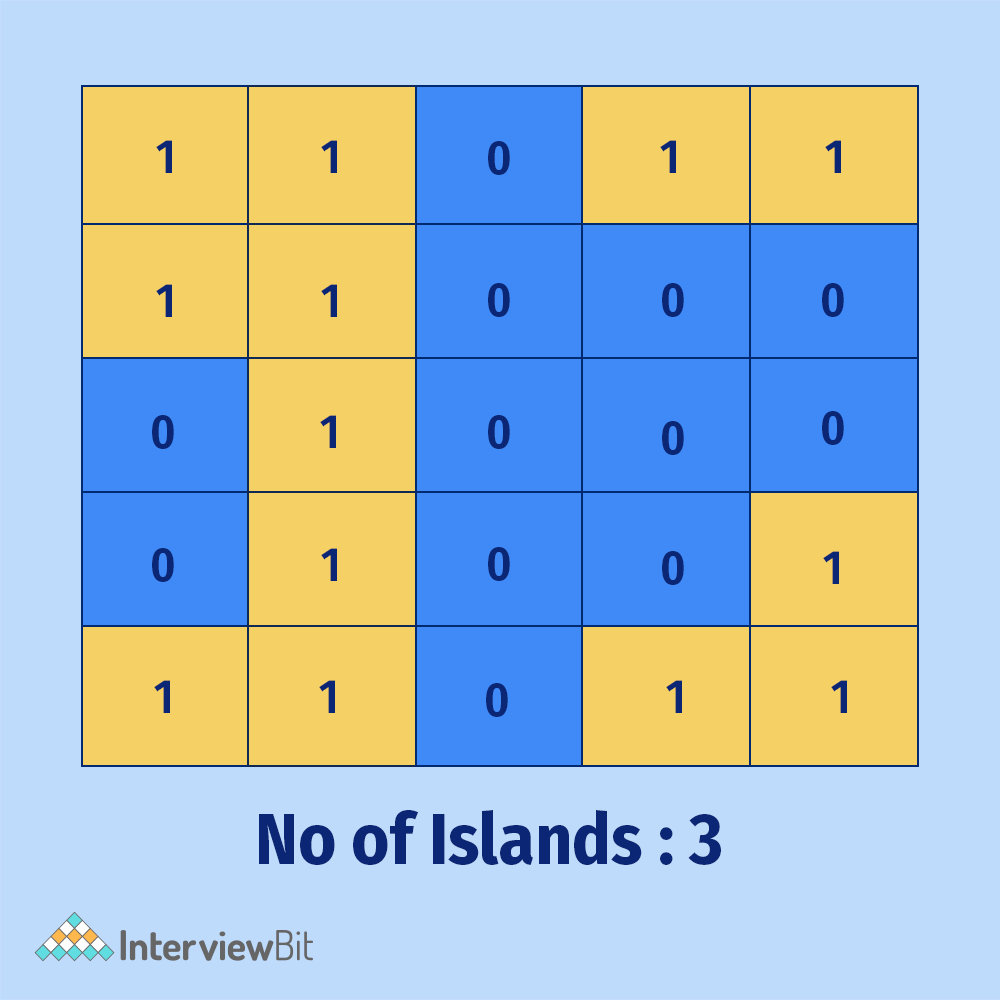

In [ ]:
def flood_fill_util(z,x ,y, new,vis):
    # we need the x and y of the start position,
    # and the new value
    # the flood fill has 4 parts
    # firstly, make sure the x and y are inbounds
    if x < 0 or x >= z.shape[0] or y < 0 or y >= z.shape[1]:
        return
    # secondly, check if the current position equals to zero(no field) or we already visited it
    if (z[x][y] == 0 or vis[x][y]):
        return
    # thirdly, set the current position to the new value
    z[x][y] = new
    vis[x][y]=1
    # fourthly, attempt to fill the neighboring positions
    flood_fill_util(z,x+1, y,  new,vis)
    flood_fill_util(z,x-1, y,  new,vis)
    flood_fill_util(z,x, y+1,  new,vis)
    flood_fill_util(z,x, y-1,  new,vis)
    flood_fill_util(z,x-1, y-1, new,vis)
    flood_fill_util(z,x-1, y+1, new,vis)
    flood_fill_util(z,x+1, y-1, new,vis)
    flood_fill_util(z,x+1, y+1, new,vis)

In [ ]:
def flood_fill(z,color):
  field=z.copy()
  n,m=field.shape
  vis=np.zeros((n,m))
  for i in range(n):
    for j in range(m):
      if(vis[i][j]==0 and field[i][j]!=0):
        flood_fill_util(field,i,j,color,vis)
        color+=1
  return field,color      

In [ ]:
def get_components_per_chip(collection, folder_ids):

    D = {}
    pbar = tqdm(folder_ids)
    pbar.set_description(f'Extracting {collection}',)
    color=7999#random number ,i choosed >max(field id) to avoid confusion
    for idx in pbar:
        
        with rasterio.open(f'./{main}/{collection}/{collection}_{idx}/field_ids.tif') as field:
            arr = field.read()[0]
            
            components,color=flood_fill(arr,color)
            color+=1
            for i in range(256):
              for j in range(256):
                if(arr[i][j]!=0):
                  D[arr[i][j]]=components[i][j]
    return D              

In [ ]:
D=get_components_per_chip(train_label_collection, train_folder_ids)

Extracting ref_agrifieldnet_competition_v1_labels_train: 100%|██████████| 1165/1165 [06:39<00:00,  2.92it/s]


In [ ]:
train_components=pd.DataFrame()
train_components['field_id']=list(D.keys())
train_components['component']=list(D.values())
train_components

,field_id,component
0,757,7999
1,756,8000
2,1372,9617
3,1374,9617
4,1986,8004
...,...,...
5546,1385,13260
5547,789,13260
5548,923,13261
5549,924,13262


In [ ]:
train_components.to_csv('train_components.csv',index=False)

In [ ]:
D=get_components_per_chip(test_label_collection, test_folder_ids)

Extracting ref_agrifieldnet_competition_v1_labels_test: 100%|██████████| 707/707 [03:53<00:00,  3.03it/s]


In [ ]:
test_components=pd.DataFrame()
test_components['field_id']=list(D.keys())
test_components['component']=list(D.values())
test_components

,field_id,component
0,5407,7999
1,6309,8001
2,6311,8001
3,6314,8002
4,6310,8002
...,...,...
1525,2127,10104
1526,3286,10106
1527,3595,10107
1528,971,10109


In [ ]:
test_components.to_csv('test_components.csv',index=False)

##We're done let's start modelling